# About this kernel

This is a rather quick and dirty kernel I created, with two ideas in mind: Training a "2-headed" network that will learn to predict siRNA using images from both sites at the same time, and split the learning process into two stages, namely first training on all data, then training the CNN on data from a single experiment at a time. The second idea comes from [this thread by Phalanx](https://www.kaggle.com/c/recursion-cellular-image-classification/discussion/100414#latest-586901). The data comes from my previous kernel on preprocessing.

Here are the relevant sections:
* **Data Generator**: The `__generate_X` method is pretty different, since it loads two images at the same time. Everything else is standard
* **Model**: The CNN architecture used here is `EfficientNetB2`. With the right learning rates and enough time, you can probably try B1-B5; they have unfortunately not succeeded in my case. The inputs are two images, i.e. from site 1 and site 2. The two images are passed through the same CNN, then global-average-pooled, and added to form a single 1280-dimensional vector, which is ultimately used to perform predictions. This means that the networks will be updated simultaneously from the gradients of both sites.
* **Phase 1**: Train the model on all data from 10 epochs, and save results to `model.h5`.
* **Phase 2**: Load `model.h5` and train the model for 15 epochs on data from a single cell line, i.e. *HEPG2, HUVEC, RPE, U2OS*.

## Changelog

* V20: Added random flipping.

In [1]:
!pip install efficientnet
import efficientnet

  Created wheel for efficientnet: filename=efficientnet-0.0.4-cp36-none-any.whl size=14289 sha256=7b080579cae27292bf708c9d76aeb9d18d0340d0839d1f514d4ac5cfded4f8f2
  Stored in directory: /tmp/.cache/pip/wheels/5c/34/68/a611a699a28239e964ccf144c0e767cdb5439fee82ec5de6e0
Successfully built efficientnet


Using TensorFlow backend.


In [2]:
import json
import math
import os

import cv2
import tensorflow as tf
from PIL import Image
import numpy as np
import keras
from keras import layers
from keras.applications import MobileNetV2
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, concatenate, Input, add
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm

# Preprocessing

In [3]:
train_df = pd.read_csv('../input/recursion-cellular-image-classification/train.csv')
test_df = pd.read_csv('../input/recursion-cellular-image-classification/test.csv')

train_df['category'] = train_df['experiment'].apply(lambda x: x.split('-')[0])
test_df['category'] = test_df['experiment'].apply(lambda x: x.split('-')[0])

train_target_df = pd.get_dummies(train_df['sirna'])

print(train_df.shape)
print(test_df.shape)
print(train_target_df.shape)

train_df.head()

(36515, 6)
(19897, 5)
(36515, 1108)


,id_code,experiment,plate,well,sirna,category
0,HEPG2-01_1_B03,HEPG2-01,1,B03,513,HEPG2
1,HEPG2-01_1_B04,HEPG2-01,1,B04,840,HEPG2
2,HEPG2-01_1_B05,HEPG2-01,1,B05,1020,HEPG2
3,HEPG2-01_1_B06,HEPG2-01,1,B06,254,HEPG2
4,HEPG2-01_1_B07,HEPG2-01,1,B07,144,HEPG2


In [4]:
train_idx, val_idx = train_test_split(
    train_df.index, test_size=0.15, random_state=2019
)

print(train_idx.shape)
print(val_idx.shape)

(31037,)
(5478,)


# Data Generator

In [5]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path = '../input/recursion-cellular-image-classification-224-jpg/train/train',
                 batch_size=32, dim=(224, 224), n_channels=3,
                 rotation_range=0, fill_mode='nearest', swap=False,
                 vertical_flip=False, horizontal_flip=False, rescale=1/255.,
                 n_classes=5, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.rotation_range=rotation_range
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.rescale = rescale
        self.vertical_flip = vertical_flip
        self.horizontal_flip = horizontal_flip
        self.random_state = random_state
        self.swap = swap
        
        self.fill_mode = self.__compute_fill_mode(fill_mode)
        
        np.random.seed(self.random_state)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('The parameter mode should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X_1 = np.empty((self.batch_size, *self.dim, self.n_channels))
        X_2 = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            ext = 'jpeg'
            
            code = self.df['id_code'].iloc[ID]
            
            img_path_1 = f"{self.base_path}/{code}_s1.{ext}"
            img_path_2 = f"{self.base_path}/{code}_s2.{ext}"
            
            img1 = self.__load_image(img_path_1)
            img2 = self.__load_image(img_path_2)
            
            if self.swap and np.random.rand() > 0.5:
                img1, img2 = img2, img1
            
            # Store samples
            X_1[i,] = img1
            X_2[i,] = img2

        return [X_1, X_2]
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            sirna = self.target_df.iloc[ID]
            y[i, ] = sirna
        
        return y
    
    def __load_image(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = self.rescale * img.astype(np.float32)

        return img
    
    def __compute_fill_mode(self, fill_mode):
        convert_cv2 = {
            'nearest': cv2.BORDER_REPLICATE,
            'reflect': cv2.BORDER_REFLECT,
            'wrap': cv2.BORDER_WRAP,
            'constant': cv2.BORDER_CONSTANT
        }
        
        return convert_cv2[fill_mode]
    
    def __random_transform(img):
        if np.random.rand() > 0.5 and self.vertical_flip:
            img = cv2.flip(img, 0)
        if np.random.rand() > 0.5 and self.horizontal_flip:
            img = cv2.flip(img, 1)
        
        # Random Rotation
        rotation = self.rotation_range * np.random.rand()
        
        rows,cols = img.shape[:2]
        M = cv2.getRotationMatrix2D((cols/2,rows/2),rotation,1)
        img = cv2.warpAffine(img,M,(cols,rows), borderMode=self.fill_mode)
        
        return img

In [6]:
BATCH_SIZE = 32
train_generator = DataGenerator(
    train_idx, 
    df=train_df,
    target_df=train_target_df,
    batch_size=BATCH_SIZE, 
    vertical_flip=True,
    horizontal_flip=True,
    swap=True,
    rotation_range=15,
    n_classes=train_target_df.shape[1]
)

val_generator = DataGenerator(
    val_idx, 
    df=train_df,
    target_df=train_target_df,
    batch_size=BATCH_SIZE, 
    vertical_flip=True,
    horizontal_flip=True,
    swap=True,
    rotation_range=15,
    n_classes=train_target_df.shape[1]
)

test_generator = DataGenerator(
    test_df.index, 
    df=test_df,
    batch_size=1, 
    shuffle=False,
    mode='predict',
    n_classes=train_target_df.shape[1],
    base_path='../input/recursion-cellular-image-classification-224-jpg/test/test/'
)

# Model

In [7]:
def build_model(n_classes):
    # First load mobilenet
    backbone = efficientnet.EfficientNetB3(
        weights='imagenet', 
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    im_inp_1 = Input(shape=(224, 224, 3))
    im_inp_2 = Input(shape=(224, 224, 3))

    x1 = backbone(im_inp_1)
    x2 = backbone(im_inp_2)

    x1 = GlobalAveragePooling2D()(x1)
    x2 = GlobalAveragePooling2D()(x2)

    out = add([x1, x2])
    out = Dropout(0.5)(out)

    out = Dense(n_classes, activation='softmax')(out)

    model = Model(inputs=[im_inp_1, im_inp_2], outputs=out)
    
    model.compile(Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Phase 1: Train on all data

In [8]:
model = build_model(n_classes=train_target_df.shape[1])
model.summary()

43974656/43966704 [==============================] - 4s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
efficientnet-b3 (Model)         (None, 7, 7, 1536)   10783528    input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 1536)

In [9]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=1,
    verbose=2,
    epochs=20
)

Epoch 1/20
 - 995s - loss: 6.9785 - acc: 0.0026 - val_loss: 6.6790 - val_acc: 0.0058
Epoch 2/20
 - 925s - loss: 6.4195 - acc: 0.0146 - val_loss: 6.0393 - val_acc: 0.0349
Epoch 3/20
 - 925s - loss: 5.7819 - acc: 0.0445 - val_loss: 5.5030 - val_acc: 0.0704
Epoch 4/20
 - 925s - loss: 5.1843 - acc: 0.0905 - val_loss: 5.0186 - val_acc: 0.1232
Epoch 5/20
 - 925s - loss: 4.6569 - acc: 0.1464 - val_loss: 4.6993 - val_acc: 0.1520
Epoch 6/20
 - 926s - loss: 4.1900 - acc: 0.2030 - val_loss: 4.4238 - val_acc: 0.1811
Epoch 7/20
 - 926s - loss: 3.7453 - acc: 0.2675 - val_loss: 4.2220 - val_acc: 0.2155
Epoch 8/20
 - 923s - loss: 3.3458 - acc: 0.3291 - val_loss: 4.0493 - val_acc: 0.2361
Epoch 9/20
 - 924s - loss: 2.9923 - acc: 0.3881 - val_loss: 3.9706 - val_acc: 0.2440
Epoch 10/20
 - 923s - loss: 2.6716 - acc: 0.4438 - val_loss: 3.8502 - val_acc: 0.2617
Epoch 11/20
 - 923s - loss: 2.3557 - acc: 0.5025 - val_loss: 3.7738 - val_acc: 0.2749
Epoch 12/20
 - 922s - loss: 2.0722 - acc: 0.5569 - val_loss: 3.

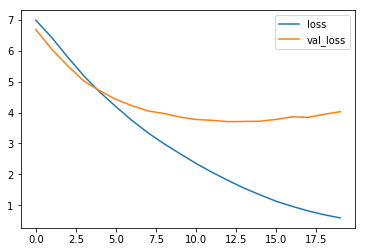

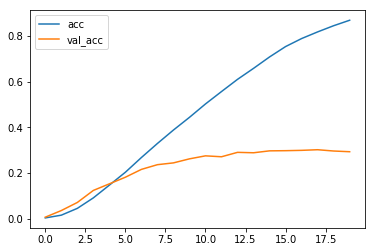

In [10]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

# Phase 2: train on each cell line

In [11]:
categories = train_df['category'].unique()
output_df = []

for category in categories:
    # Retrieve desired category
    category_df = train_df[train_df['category'] == category]
    cat_test_df = test_df[test_df['category'] == category].copy()
    
    print('\n' + '=' * 40)
    print("CURRENT CATEGORY:", category)
    print('-' * 40)
    
    train_idx, val_idx = train_test_split(
        category_df.index, 
        random_state=2019,
        test_size=0.15
    )
    
    # Create new generators
    train_generator = DataGenerator(
        train_idx, 
        df=train_df,
        target_df=train_target_df,
        batch_size=BATCH_SIZE, 
        vertical_flip=True,
        horizontal_flip=True,
        swap=True,
        rotation_range=15,
        n_classes=train_target_df.shape[1]
    )

    val_generator = DataGenerator(
        val_idx, 
        df=train_df,
        target_df=train_target_df,
        batch_size=BATCH_SIZE, 
        vertical_flip=True,
        horizontal_flip=True,
        swap=True,
        rotation_range=15,
        n_classes=train_target_df.shape[1]
    )

    test_generator = DataGenerator(
        cat_test_df.index, 
        df=test_df,
        batch_size=1, 
        shuffle=False,
        mode='predict',
        n_classes=train_target_df.shape[1],
        base_path='../input/recursion-cellular-image-classification-224-jpg/test/test/'
    )

    # Restore previously trained model
    model.load_weights('model.h5')
    model.compile(
        Adam(0.0001), 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )

    # Train model only on data for specific category
    checkpoint = ModelCheckpoint(
        f'model_{category}.h5', 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False,
        mode='auto'
    )

    history_category = model.fit_generator(
        train_generator,
        validation_data=val_generator,
        callbacks=[checkpoint],
        use_multiprocessing=False,
        workers=1,
        verbose=2,
        epochs=10
    )

    # Make prediction and add to output dataframe
    y_pred = model.predict_generator(
        test_generator,
        workers=2,
        use_multiprocessing=True,
        verbose=1
    )

    cat_test_df['sirna'] = y_pred.argmax(axis=1)
    output_df.append(cat_test_df[['id_code', 'sirna']])

    # Save history
    with open(f'history_{category}.json', 'w') as f:
        json.dump(history_category.history, f)


CURRENT CATEGORY: HEPG2
----------------------------------------
Epoch 1/10
 - 239s - loss: 3.5463 - acc: 0.3067 - val_loss: 2.0713 - val_acc: 0.6510
Epoch 2/10
 - 196s - loss: 2.5745 - acc: 0.4832 - val_loss: 2.0016 - val_acc: 0.6467
Epoch 3/10
 - 196s - loss: 2.0689 - acc: 0.6006 - val_loss: 1.9513 - val_acc: 0.6484
Epoch 4/10
 - 196s - loss: 1.6707 - acc: 0.6802 - val_loss: 1.9349 - val_acc: 0.6389
Epoch 5/10
 - 196s - loss: 1.3474 - acc: 0.7453 - val_loss: 1.9298 - val_acc: 0.6415
Epoch 6/10
 - 196s - loss: 1.1235 - acc: 0.7971 - val_loss: 1.8925 - val_acc: 0.6328
Epoch 7/10
 - 196s - loss: 0.8849 - acc: 0.8524 - val_loss: 1.8872 - val_acc: 0.6354
Epoch 8/10
 - 196s - loss: 0.7310 - acc: 0.8837 - val_loss: 1.8865 - val_acc: 0.6363
Epoch 9/10
 - 196s - loss: 0.6062 - acc: 0.9116 - val_loss: 1.8940 - val_acc: 0.6198
Epoch 10/10
 - 196s - loss: 0.4881 - acc: 0.9343 - val_loss: 1.8889 - val_acc: 0.6215
4429/4429 [==============================] - 190s 43ms/step

CURRENT CATEGORY: HUVE

# Submission

In [12]:
output_df = pd.concat(output_df)
output_df.to_csv('submission.csv', index=False)